# Quads design (3dp pla + blue shims) for energy focusing with single target region


## Imports


NOTE: Please download data associated to this repository from https://doi.org/10.5281/zenodo.12823471


In [1]:
from difflexmm.utils import SolutionData, save_data, load_data
from difflexmm.geometry import QuadGeometry, compute_inertia
from difflexmm.energy import kinetic_energy
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_focusing import ForwardProblem, OptimizationProblem
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import to_rgba
from matplotlib import patches
from pathlib import Path
from typing import Any, Optional

import jax.numpy as jnp
from jax import random
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions


In [2]:
def plot_objective_and_constraints_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(nrows=3, figsize=figsize,
                             sharex=True, constrained_layout=True)
    axes[0].set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    axes[0].plot(jnp.array(optimization.objective_values) /
                 optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes[0].axhline(y=0, color="black")
    axes[1].set_ylabel("Overlap", fontsize=fontsize)
    axes[1].plot(optimization.constraints_violation["angles"],
                 lw=3, color="#c0392b")
    axes[1].axhline(y=0, color="black")
    axes[2].set_ylabel("Edge-length [mm]", fontsize=fontsize)
    axes[2].plot(optimization.constraints_violation["edge_lengths"],
                 lw=3, color="#c0392b")
    axes[2].axhline(y=0, color="black")
    axes[-1].set_xlabel(r"Iteration \#", fontsize=fontsize)
    # Change fontsize for all axes
    for ax in axes:
        ax.tick_params(labelsize=fontsize)
    if not grid:
        for ax in axes:
            ax.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_and_constraints_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(
        figsize=figsize, sharex=True, constrained_layout=True)
    axes.plot(jnp.array(optimization.objective_values) /
              optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes.axhline(y=0, color="black")
    axes.set_xlabel(r"Iteration \#", fontsize=fontsize)
    axes.set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    # Make spines 1pt thick
    for spine in axes.spines.values():
        spine.set_linewidth(1)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )


def plot_design_and_objective(optimization: OptimizationProblem, iteration: int, figsize=(13, 6), fontsize=None, ticksize=None, energy_map=False, cmap="inferno", scaling=1.0, cmap_label=r"Average kinetic energy [mJ]", vmin=None, vmax=None):
    problem = optimization.forward_problem
    if not problem.is_setup:
        problem.setup()

    iteration = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration

    xlim, ylim = problem.geometry.get_xy_limits(
        *optimization.design_values[-1]) + 0.1*problem.geometry.spacing * jnp.array([-1, 1])

    fig, axes = plt.subplot_mosaic(
        'AADDDDD;AADDDDD;BBDDDDD;CCDDDDD', figsize=figsize, constrained_layout=True)

    # Objective and constraints
    axes["A"].set_ylabel(
        "Energy focused at\ntarget region [mJ]", fontsize=fontsize)
    plot_A, = axes["A"].plot(jnp.array(optimization.objective_values) /
                             problem.n_timepoints, lw=3, color="#27ae60")
    axes["A"].fill_between(
        jnp.arange(iteration),
        jnp.array(optimization.objective_values)[:iteration] /
        problem.n_timepoints,
        color="#27ae60",
        alpha=0.3,
    )
    # axes["A"].set_title("Objective", fontsize=fontsize)
    plot_A.set_data(jnp.arange(iteration), jnp.array(optimization.objective_values)[:iteration] /
                    problem.n_timepoints)
    axes["A"].axhline(y=0, lw=1, color="black")
    axes["A"].set_xticklabels([])

    axes["B"].set_ylabel("Overlap\nconstraints", fontsize=fontsize)
    plot_B, = axes["B"].plot(
        optimization.constraints_violation["angles"], lw=3, color="#c0392b")
    axes["B"].fill_between(
        jnp.arange(iteration),
        optimization.constraints_violation["angles"][:iteration],
        color="#c0392b",
        alpha=0.3,
    )
    plot_B.set_data(jnp.arange(
        iteration), optimization.constraints_violation["angles"][:iteration])
    axes["B"].axhline(y=0, lw=1, color="black")
    axes["B"].set_xticklabels([])
    # axes["B"].set_title("Constraints", fontsize=fontsize)

    axes["C"].set_xlabel(r"Iteration \#", fontsize=fontsize)
    axes["C"].set_ylabel("Edge-length\nconstraints", fontsize=fontsize)
    plot_C, = axes["C"].plot(
        optimization.constraints_violation["edge_lengths"], lw=3, color="#c0392b")
    axes["C"].fill_between(
        jnp.arange(iteration),
        optimization.constraints_violation["edge_lengths"][:iteration],
        color="#c0392b",
        alpha=0.3,
    )
    plot_C.set_data(jnp.arange(
        iteration), optimization.constraints_violation["edge_lengths"][:iteration])
    axes["C"].axhline(y=0, lw=1, color="black")
    # Change fontsize for all axes
    for ax in axes.values():
        ax.tick_params(labelsize=ticksize)
        # ax.grid(False)
        # Make spines 1pt thick
        for spine in ax.spines.values():
            spine.set_linewidth(1)

    # Design
    axes["D"].set_title(
        rf"Design \#{iteration:02d}", y=-0.085, fontsize=fontsize)
    axes["D"].axis("off")
    axes["D"].axis("equal")
    fig, _ = plot_geometry(
        block_centroids=problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=problem.geometry.bond_connectivity(),
        xlim=xlim,
        ylim=ylim,
        # figsize=(10, 7),
        ax=axes["D"],
    )
    if energy_map:
        field_values = average_kinetic_energy_per_block(
            optimization.responses[iteration],
            compute_inertia(
                vertices=optimization.responses[iteration].centroid_node_vectors,
                density=optimization.forward_problem.density,
            )
        )
        axes["D"].collections[0].set_array(field_values)
        axes["D"].collections[0].set_cmap(cmap)
        axes["D"].collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling,
                vmin=jnp.min(field_values) if vmin is None else vmin,
                vmax=jnp.max(field_values) if vmax is None else vmax,
            )
        )
        cb = fig.colorbar(axes["D"].collections[0], ax=axes["D"], pad=0.01, aspect=30)
        cb.ax.tick_params(labelsize=ticksize)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    # Draw highlighted region
    highlighted_region = patches.Rectangle(
        (((problem.geometry.n1_blocks-optimization.target_size[0])//2 + optimization.target_shift[0]-1)*problem.geometry.spacing,
         ((problem.geometry.n2_blocks-optimization.target_size[1])//2 + optimization.target_shift[1]-1)*problem.geometry.spacing),
        (optimization.target_size[0]+1)*problem.geometry.spacing,
        (optimization.target_size[1]+1)*problem.geometry.spacing,
        facecolor=to_rgba("#27ae60", 0.3),
        edgecolor="#27ae60",
        linewidth=3,
        zorder=10,
    )
    axes["D"].add_patch(highlighted_region)
    # Add annotation to highlighted region
    axes["D"].annotate(
        r"\textbf{Target region}",
        xy=(
            ((problem.geometry.n1_blocks -
              optimization.target_size[0])//2 + optimization.target_shift[0]-1)*problem.geometry.spacing+(optimization.target_size[0]+1)*problem.geometry.spacing/2,
            ((problem.geometry.n2_blocks -
              optimization.target_size[1])//2 + optimization.target_shift[1]-1)*problem.geometry.spacing+(optimization.target_size[1]+1)*problem.geometry.spacing,
        ),
        xytext=(
            ((problem.geometry.n1_blocks -
              optimization.target_size[0])//2 + optimization.target_shift[0]-1)*problem.geometry.spacing+(optimization.target_size[0]+1)*problem.geometry.spacing/2,
            ((problem.geometry.n2_blocks -
              optimization.target_size[1])//2 + optimization.target_shift[1]-1)*problem.geometry.spacing+(optimization.target_size[1]+2.7)*problem.geometry.spacing,
        ),
        xycoords="data",
        textcoords="data",
        ha="center",
        va="bottom",
        color="white",
        arrowprops=dict(arrowstyle="-", color="#27ae60",
                        lw=3, shrinkA=0, shrinkB=0),
        bbox=dict(facecolor=to_rgba("#27ae60", 1.),
                  edgecolor="none", boxstyle="round,pad=0.2"),
        fontsize=fontsize,
    )

    fig.align_ylabels()

    return fig, axes


def generate_response_animation(
        optimization: OptimizationProblem,
        optimization_filename: str,
        animation_filename: str = "response_animation",
        iteration=-1,
        field: str = "v",
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    if iteration >= 0:
        solution = optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )
    else:
        solution = optimization.forward_problem.solution_data if optimization.forward_problem.solution_data is not None else optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + optimization.forward_problem.spacing * jnp.array([[-1.25, 1.25], [-1., 1.]])

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    # Drop alien stuff from plot_kwargs
    plot_kwargs.pop("field", None)
    plot_kwargs.pop("animation_filename", None)
    plot_kwargs.pop("iteration", None)
    generate_animation(
        data=solution,
        field=field,
        out_filename=f"../out/{optimization.name}/{optimization_filename}/{animation_filename}_design_{iteration_label:03d}",
        deformed=True,
        xlim=xlim,
        ylim=ylim,
        **plot_kwargs
    )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap: Any = "inferno", color=None, cmap_label=None, scaling=1., deformed=False, block_displacements=None, vmin=None, vmax=None):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.spacing * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        deformed=deformed,
        block_displacements=block_displacements,
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling,
                vmin=jnp.min(field_values) if vmin is None else vmin,
                vmax=jnp.max(field_values) if vmax is None else vmax,
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=30)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes


In [3]:
def kinetic_energy_integrated(solution_data: SolutionData, target_blocks: jnp.ndarray, density: jnp.ndarray):
    return kinetic_energy(
        solution_data.fields[:, 1, target_blocks, :],
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=density,
        )[target_blocks]
    )*(solution_data.timepoints[1]-solution_data.timepoints[0])


def kinetic_energy_integrated_ratio(solution_data: SolutionData, target_blocks: jnp.ndarray, density: jnp.ndarray):
    all_blocks = jnp.arange(solution_data.block_centroids.shape[0])
    non_target_blocks = jnp.setdiff1d(all_blocks, target_blocks)
    return kinetic_energy_integrated(solution_data, target_blocks, density) / kinetic_energy_integrated(solution_data, non_target_blocks, density)


def plot_performance_contour(frequencies, amplitudes, performance_values, figsize=(4, 3), fontsize=None, levels=20, cmap="inferno", label="Focused energy [mJ s]", cb_loc=None):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    contour = axes.contourf(frequencies, amplitudes, performance_values.T, levels=levels, cmap=cmap)
    # f, a = jnp.meshgrid(frequencies, amplitudes)
    # contour = axes.tripcolor(f.flatten(), a.flatten(), performance_values.T.flatten(), cmap=cmap, shading='gouraud')
    axes.set_xlabel(r"Frequency [Hz]", fontsize=fontsize)
    axes.set_ylabel(r"Amplitude [mm]", fontsize=fontsize)
    axes.tick_params(labelsize=0.8*fontsize)
    axes.set_xticks(frequencies)
    axes.set_yticks(amplitudes)
    axes.set_xlim(frequencies.min(), frequencies.max())
    axes.set_ylim(amplitudes.min(), amplitudes.max())
    # Make spines 1pt thick
    for spine in axes.spines.values():
        spine.set_linewidth(1)
    cb = fig.colorbar(contour, ax=axes, aspect=30, pad=0.01, location=cb_loc)
    cb.ax.tick_params(labelsize=0.8*fontsize)
    # Set colorbar ticklabel format to be %.2f
    cb.formatter = plt.FuncFormatter(lambda x, pos: f"{x:.2f}")
    cb.update_ticks()
    if cb_loc is None or cb_loc == "right":
        cb.ax.set_yticks(jnp.linspace(performance_values.min(), performance_values.max(), 3))
    elif cb_loc == "bottom":
        cb.ax.set_xticks(jnp.linspace(performance_values.min(), performance_values.max(), 3))

    cb.set_label(label, fontsize=fontsize)

    return fig, axes


## Optimal design and response


In [4]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 16
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design
# Randomly perturb design
key_h = 0
key_v = key_h+1
noise_amplitude = 0.15
horizontal_shifts = horizontal_shifts + random.uniform(random.PRNGKey(key_h), horizontal_shifts.shape, minval=-1, maxval=1)*noise_amplitude*spacing
vertical_shifts = vertical_shifts + random.uniform(random.PRNGKey(key_v), vertical_shifts.shape, minval=-1, maxval=1)*noise_amplitude*spacing

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Dynamic loading
amplitude = 0.5 * spacing
frequency = 30.  # Hz loading frequency for dynamic input

# Forward problem
problem = ForwardProblem(
    # Geometrical params
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    # Mechanical params
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    use_contact=True,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    # Dynamic loading
    amplitude=amplitude,
    loading_rate=frequency,
    input_delay=0.1*frequency**-1,
    n_excited_blocks=2,
    loaded_side="left",
    input_shift=0,
    # Analysis params
    simulation_time=2*frequency**-1,  # s
    n_timepoints=200,
    # Solver tolerances
    atol=1e-4,
    # Problem name (folder name)
    name="quads_focusing_3dp_pla_shims",
)

# Optimization problem
target_size = (2, 2)
target_shift = (4, 5)
optimization = OptimizationProblem(
    forward_problem=problem,
    target_size=target_size,
    target_shift=target_shift,
    name=problem.name,
)

problem_filename = f"quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_random_initial_design_noise_{noise_amplitude:.2f}_keys_{key_h}_{key_v}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename}_target_size_{optimization.target_size[0]}x{optimization.target_size[1]}_target_shift_{optimization.target_shift[0]}x{optimization.target_shift[1]}"


### Import most recent optimization object


In [5]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
# optimization.run_optimization_nlopt(
#     initial_guess=(horizontal_shifts, vertical_shifts),
#     # initial_guess=optimization.design_values[-1],
#     n_iterations=60,
#     min_block_angle=30*jnp.pi/180,
#     # Highly disordered initial designs may need boundary angle constraints to avoid unfeasible designs, change to True if needed.
#     boundary_angle_constraint=False,
#     min_void_angle=0*jnp.pi/180,
#     min_edge_length=3.,  # mm
#     max_time=12*60*60,  # 8 hour
#     # lower_bound=-0.22*optimization.forward_problem.spacing,
#     # upper_bound=0.22*optimization.forward_problem.spacing,
# )

# save_data(
#     f"../data/{optimization.name}/{optimization_filename}.pkl",
#     optimization.to_dict()  # Optimization problem
# )

## Plots


### Objective iterations


In [ ]:
plot_objective_and_constraints_iterations(
    optimization,
    optimization_filename=optimization_filename,
    figsize=(7, 6),
    fontsize=14,
)


### Response animation


In [ ]:
# Initial design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=0,
)


In [ ]:
# Best design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)


### Plot designs


(<Figure size 700x466.667 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

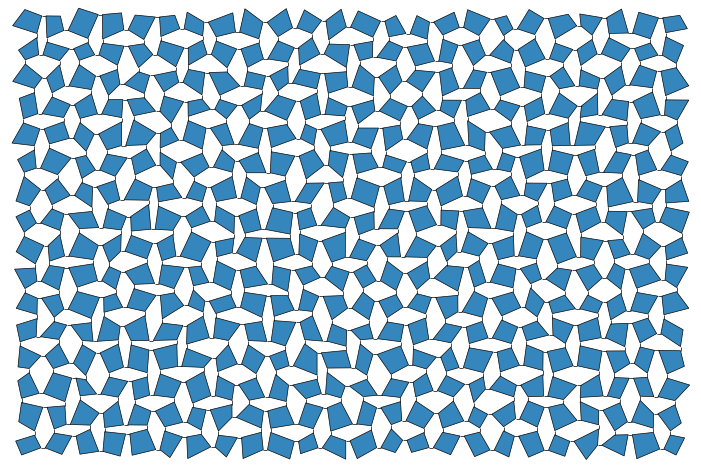

In [9]:
# Initial design
plot_design(
    optimization,
    optimization_filename=optimization_filename,
    iteration=0,
    figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    grid=False,
    axis=False,
)


(<Figure size 700x466.667 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

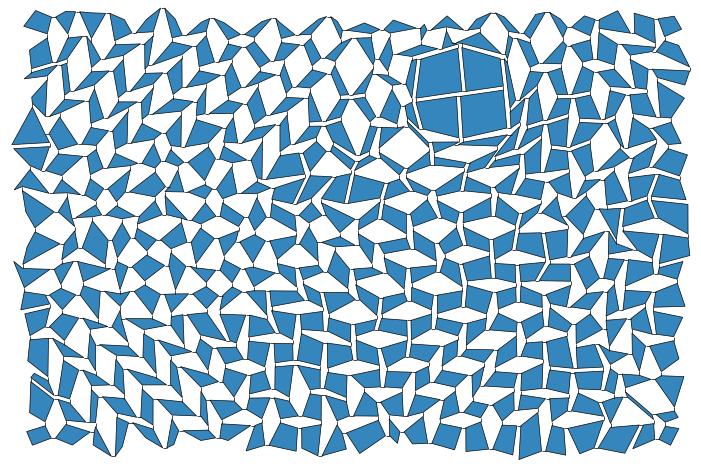

In [10]:
# Best design
plot_design(
    optimization,
    optimization_filename=optimization_filename,
    iteration=-1,
    figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    grid=False,
    axis=False,
)


### Plot average kinetic energy distribution


In [61]:
optimization.forward_problem.setup()

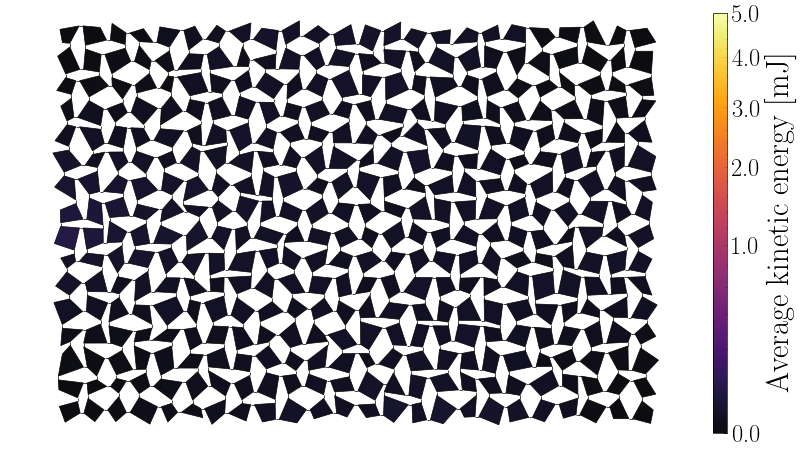

In [62]:
# Initial design
iteration = 0
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration]
)
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    scaling=0.5,
    vmin=0,
    vmax=5.,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

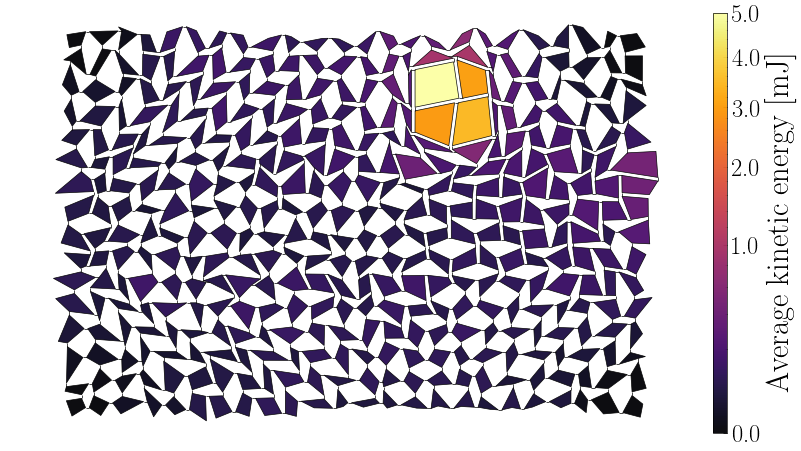

In [63]:
# Best design
iteration = -1
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration]
)
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    scaling=0.5,
    vmin=0,
    vmax=5.,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

## Similarity with regular initial design

In [6]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471

# Regular initial design
optimization_filename_regular = "opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5"
optimization_regular = OptimizationProblem.from_dict(
    load_data(
        f"../data/quads_focusing_3dp_pla_shims/{optimization_filename_regular}.pkl",
    )
)

# Random initial design
keys_sweep = [0, 2, 4, 6]
noise_amplitude_sweep = [0.1, 0.15, 0.2]
optimizations_random_initial_design = [
    [
        OptimizationProblem.from_dict(
            load_data(
                f"../data/quads_focusing_3dp_pla_shims/opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_random_initial_design_noise_{noise_amplitude:.2f}_keys_{key}_{key+1}_target_size_2x2_target_shift_4x5.pkl",
            )
        )
        for key in keys_sweep
    ]
    for noise_amplitude in noise_amplitude_sweep
]

### Performance

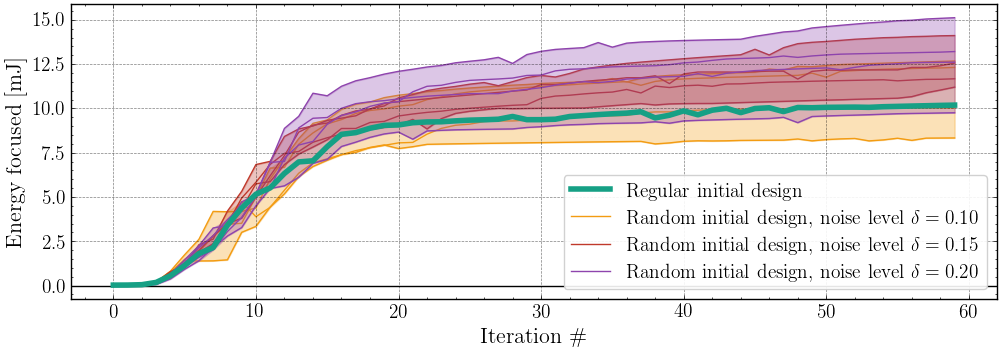

In [7]:
color_regular = "#16a085"
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "noise",
    ("#34495e", "#c0392b"),
)
colors_random_initial_design = ["#f39c12", "#c0392b", "#8e44ad"] #cmap(jnp.linspace(0, 1, len(noise_amplitude_sweep)))

fig, axes = plt.subplots(figsize=(10, 3.5), constrained_layout=True)
# Plot regular initial design
axes.plot(
    jnp.array(optimization_regular.objective_values) /
    optimization_regular.forward_problem.n_timepoints,
    lw=4, color=color_regular, label="Regular initial design",
    zorder=10,
)
# Plot random initial designs
for color, optimizations in zip(colors_random_initial_design, optimizations_random_initial_design):
    for optimization in optimizations:
        axes.plot(
            jnp.array(optimization.objective_values)[:len(optimization_regular.objective_values)] /
            optimization.forward_problem.n_timepoints,
            lw=1, color=color, label="Random initial design",
            # alpha=0.8,
            zorder=0
        )    
    
    axes.fill_between(
            jnp.arange(len(optimization_regular.objective_values)),
            jnp.array([jnp.array(opt.objective_values)[:len(optimization_regular.objective_values)] /
            opt.forward_problem.n_timepoints for opt in optimizations]).min(axis=0),
            jnp.array([jnp.array(opt.objective_values)[:len(optimization_regular.objective_values)] /
            opt.forward_problem.n_timepoints for opt in optimizations]).max(axis=0),
            color=color,
            alpha=0.3,
            zorder=0,        
        )

axes.axhline(y=0, color="black")
# axes.set_ylim(None, 18)
axes.set_xlabel(r"Iteration \#", fontsize=16)
axes.set_ylabel("Energy focused [mJ]", fontsize=16)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
# Add custom legend using lines
lines = [
    matplotlib.lines.Line2D([0], [0], color=color_regular, lw=4, label="Regular initial design"),
    *[
        matplotlib.lines.Line2D([0], [0], color=color, lw=1, label=f"Random initial design, noise level $\delta={noise_amplitude:.2f}$"
        )
        for color, noise_amplitude in zip(colors_random_initial_design, noise_amplitude_sweep)
    ]
]
axes.legend(handles=lines, fontsize=14, loc="lower right", framealpha=0.9)
axes.tick_params(labelsize=14)
fig.savefig(
    f"../out/quads_focusing_3dp_pla_shims/performance_initial_design_comparison.png",
    dpi=300,
)